In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
base = pd.read_csv('petr4_treinamento.csv')
base = base.dropna()
base.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0


In [3]:
base.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
1242,2017-12-27,15.99,16.139999,15.98,16.049999,16.017963,23552200.0
1243,2017-12-28,16.10,16.129999,16.00,16.100000,16.067865,19011500.0
1244,2017-12-29,16.10,16.100000,16.10,16.100000,16.067865,0.0


In [4]:
base_treinamento = base.iloc[:, 1:2].values
base_valor_maximo = base.iloc[:, 2:3].values

In [5]:
normalizador = MinMaxScaler(feature_range=(0,1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
base_valor_maximo_normalizada = normalizador.fit_transform(base_valor_maximo)

In [7]:
print(base_treinamento_normalizada.shape)
print(base_valor_maximo_normalizada.shape)

(1242, 1)
(1242, 1)


In [8]:
previsores = []
preco_real1 = []
preco_real2 = []
for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i-90:i, 0])
    preco_real1.append(base_treinamento_normalizada[i, 0])
    preco_real2.append(base_valor_maximo_normalizada[i, 0])
previsores, preco_real1, preco_real2 = np.array(previsores), np.array(preco_real1), np.array(preco_real2)
previsores.shape

(1152, 90)

In [9]:
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))
previsores.shape

(1152, 90, 1)

In [10]:
preco_real = np.column_stack((preco_real1, preco_real2))

In [11]:
regressor = Sequential()
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (previsores.shape[1], 1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units = 2, activation = 'linear'))

regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error',
                  metrics = ['mean_absolute_error'])

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 90, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [12]:
regressor.fit(previsores, preco_real, epochs = 100, batch_size = 32)

Epoch 1/100
36/36 [==============================] - 5s 145ms/step - loss: 0.0346 - mean_absolute_error: 0.1388
Epoch 2/100
36/36 [==============================] - 5s 143ms/step - loss: 0.0168 - mean_absolute_error: 0.1006
Epoch 3/100
36/36 [==============================] - 5s 139ms/step - loss: 0.0151 - mean_absolute_error: 0.0954
Epoch 4/100
36/36 [==============================] - 5s 139ms/step - loss: 0.0118 - mean_absolute_error: 0.0836
Epoch 5/100
36/36 [==============================] - 5s 138ms/step - loss: 0.0110 - mean_absolute_error: 0.0810
Epoch 6/100
36/36 [==============================] - 5s 135ms/step - loss: 0.0107 - mean_absolute_error: 0.0790
Epoch 7/100
36/36 [==============================] - 5s 138ms/step - loss: 0.0098 - mean_absolute_error: 0.0753
Epoch 8/100
36/36 [==============================] - 5s 136ms/step - loss: 0.0094 - mean_absolute_error: 0.0734
Epoch 9/100
36/36 [==============================] - 5s 136ms/step - loss: 0.0082 - mean_absolute_error:

In [13]:
base_teste = pd.read_csv('petr4_teste.csv')
base_teste.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,16.516966,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,16.666668,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,16.696608,37064900


In [14]:
base_teste.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
19,2018-01-29,19.67,20.049999,19.570000,19.850000,19.810381,55726200
20,2018-01-30,19.77,19.770000,19.360001,19.490000,19.451097,46203000
21,2018-01-31,19.74,19.930000,19.680000,19.700001,19.660681,41576600


In [16]:
preco_real_open = base_teste.iloc[:, 1:2].values
preco_real_high = base_teste.iloc[:, 2:3].values

In [17]:
base_completa = pd.concat((base['Open'], base_teste['Open']), axis = 0)

In [18]:
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = entradas.reshape(-1, 1)
entradas = normalizador.transform(entradas)
entradas.shape

(112, 1)

In [19]:
X_teste = []
for i in range(90, 112):
    X_teste.append(entradas[i-90:i, 0])
X_teste = np.array(X_teste)
X_teste.shape

(22, 90)

In [20]:
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))
X_teste.shape

(22, 90, 1)

In [21]:
previsoes = regressor.predict(X_teste)
previsoes = normalizador.inverse_transform(previsoes)
previsoes.shape

(22, 2)

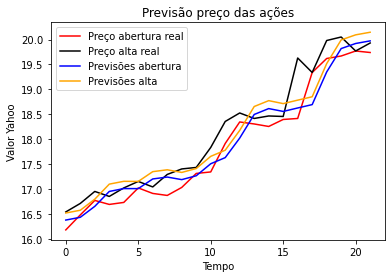

In [25]:
plt.plot(preco_real_open, color = 'red', label = 'Preço abertura real')
plt.plot(preco_real_high, color = 'black', label = 'Preço alta real')

plt.plot(previsoes[:, 0], color = 'blue', label = 'Previsões abertura')
plt.plot(previsoes[:, 1], color = 'orange', label = 'Previsões alta')

plt.title('Previsão preço das ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()